In [45]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [46]:
def reorderPts(pts):
    idx = np.lexsort((pts[:, 1], pts[:, 0]))  # 칼럼0 -> 칼럼1 순으로 정렬한 인덱스를 반환
    pts = pts[idx]  # x좌표로 정렬

    if pts[0, 1] > pts[1, 1]:
        pts[[0, 1]] = pts[[1, 0]]

    if pts[2, 1] < pts[3, 1]:
        pts[[2, 3]] = pts[[3, 2]]

    return pts

In [47]:
input_files = ['pic1.png', 'pic2.png', 'pic3.png', 'pic4.png']

imgs = []

for name in input_files:
    img = cv2.imread(name)

    if img is None:
        print('Image load failed!')
        sys.exit()

    imgs.append(img)

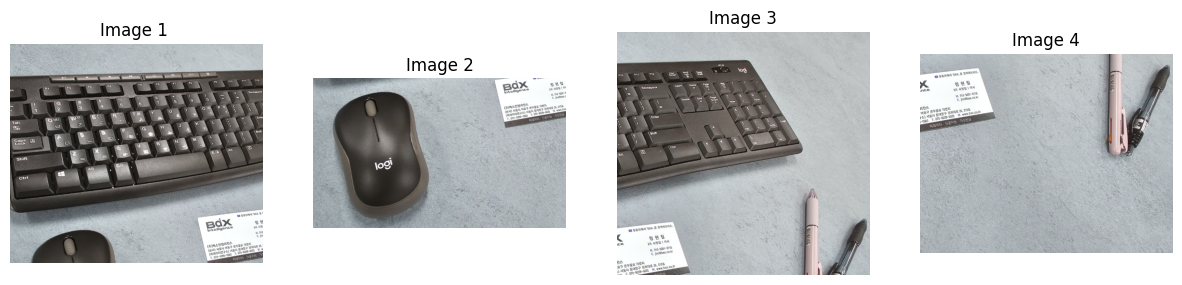

In [48]:
plt.figure(figsize=(15,8))

plt.subplot(1,4,1)
plt.imshow(imgs[0])
plt.axis('off')
plt.title('Image 1 ')

plt.subplot(1,4,2)
plt.imshow(imgs[1])
plt.axis('off')
plt.title('Image 2')

plt.subplot(1,4,3)
plt.imshow(imgs[2])
plt.axis('off')
plt.title('Image 3')

plt.subplot(1,4,4)
plt.imshow(imgs[3])
plt.axis('off')
plt.title('Image 4')
plt.show()

In [49]:
stitcher = cv2.Stitcher_create()
status, stitchImg = stitcher.stitch(imgs)

if status != cv2.Stitcher_OK:
    print('Stitch failed!')
    sys.exit()

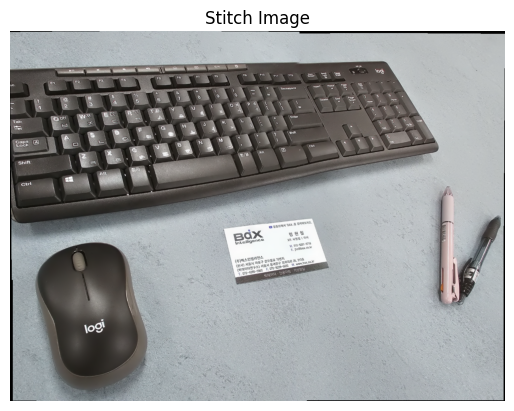

In [50]:
cv2.imwrite('result.jpg', stitchImg)

plt.imshow(stitchImg)
plt.axis('off')
plt.title('Stitch Image')
plt.show()

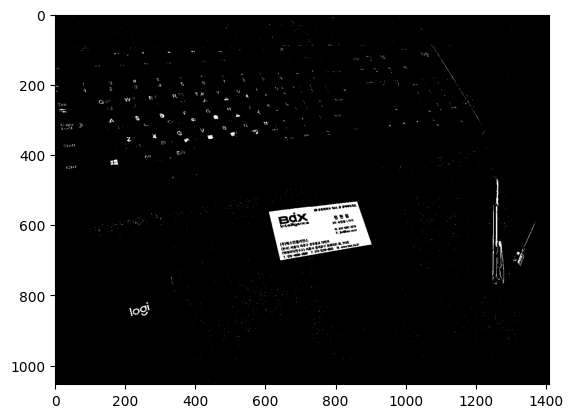

In [51]:
src_gray = cv2.cvtColor(stitchImg, cv2.COLOR_BGR2GRAY)
_, src_bin = cv2.threshold(src_gray, 210, 255, cv2.THRESH_BINARY)

# src_bin = cv2.adaptiveThreshold(src_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5)
# src_bin_local = np.zeros(src_gray.shape, np.uint8)

# bw = src_gray.shape[1] // 4
# bh = src_gray.shape[0] // 4

# for y in range(4):
#     for x in range(4):
#         src_ = src_gray[y*bh:(y+1)*bh, x*bw:(x+1)*bw]
#         dst_ = src_bin_local[y*bh:(y+1)*bh, x*bw:(x+1)*bw]
#         cv2.threshold(src_, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU, dst_)
plt.imshow(src_bin, cmap='gray')

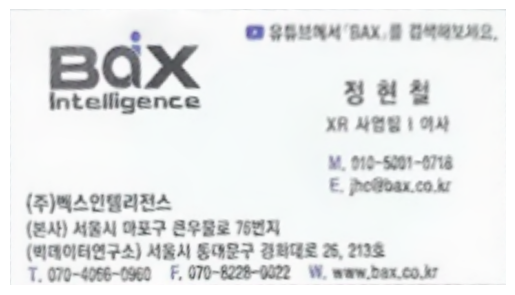

In [59]:
# 출력 영상 설정
dw, dh = 720, 400
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]], np.float32)
dst = np.zeros((dh, dw), np.uint8)

# 외곽선 검출 및 명함 검출
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cpy = stitchImg.copy()
for pts in contours:
    # 너무 작은 객체는 무시
    if cv2.contourArea(pts) < 1000:
        continue

    # # 외곽선 근사화
    approx = cv2.approxPolyDP(pts, cv2.arcLength(pts, True)*0.02, True)

    # # 컨벡스가 아니고, 사각형이 아니면 무시
    # if not cv2.isContourConvex(approx) or len(approx) != 4:
    #     continue

    
    # cv2.polylines(cpy, [approx], True, (0, 255, 0), 2, cv2.LINE_AA)
    srcQuad = reorderPts(approx.reshape(4, 2).astype(np.float32))

    (x, y, w, h) = cv2.boundingRect(approx)
    # srcQuad = np.array([[x, y], [x, y+h], [x+w, y+h], [x+w, y]], np.float32)

    # srcQuad = reorderPts(pts.reshape(4,2).astype(np.float32))

pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst = cv2.warpPerspective(stitchImg, pers, (dw, dh))

dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

plt.imshow(dst)
plt.axis('off')
# plt.title('NameCard Image')
plt.show()